In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

Notas

* En aglomerativo es posible hacer un dendrograma donde cada línea represente el color del pixel/centroide?
* Algunos algoritmos son muy lentos, se puede enviar los datos por lotes (batch)?
* qué métricas se deberían agregar?


# Funciones

In [4]:

def get_relative_paths(folder_path):
    """
    Obtiene los paths relativos de todas las imágenes en la carpeta folder_path

    Parametros:
    folder_path : str
        path de la carpeta que contiene las imágenes
    
    Returns:
    files : list
        lista con los paths relativos de todas las imágenes en la carpeta folder_path
    """
    files = []
    for root, _, filenames in os.walk(folder_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files



def plot_image(image):
    """
    Muestra la imagen en un gráfico.

    Parametros:
    image : np.array
        Arreglo con la imagen a mostrar.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



def load_images(root_path, file_names, flatten=True, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if flatten:
            img = img.reshape((-1, 3))
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list



def show_palette(cluster_centers,model_name):
    """
    Muestra la paleta de colores de la imagen.
    
    Parametros:
    cluster_centers : np.array
        Arreglo con los colores de los centros de los clusters normalizados.
    moodel_name : str
        Nombre del modelo para mostrar en el gráfico.
    """
    cluster_centers = cluster_centers * 255
    cluster_centers = cluster_centers.astype(np.uint8)
    plt.imshow([cluster_centers])
    plt.title('Paleta de colores - ' + model_name)
    plt.axis('off')
    plt.show()



def elbow_plot(X, model, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el valor de inercia
        inertias.append(model_k.inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

# test elbow_plot 
# elbow_plot(data[0].reshape(-1, 3), "kmeans", 3, 7)


# Data

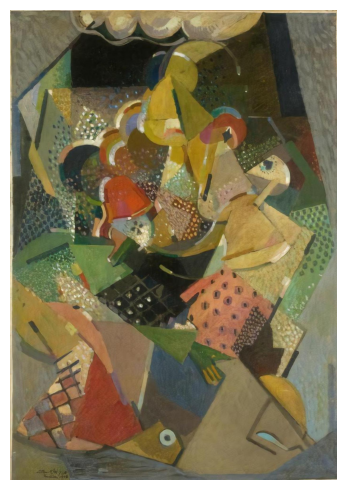

In [5]:

image_path = './Data/'

images_list = get_relative_paths(image_path)


# test load_images
image = cv2.imread(images_list[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_shape = image.shape
original_image = image

# Flatten the image
image = image.reshape((-1, 3))
# normalize
image = image / 255.0


plot_image(image.reshape(original_shape))



# Modelos

## K - means

In [ ]:

k = 5
# Modelo
kmeans = KMeans(n_clusters=k)
# Entrenamos el modelo
kmeans.fit(image)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
segmented_image = cluster_centers[labels].reshape(image.shape)


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


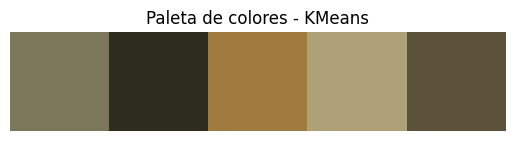

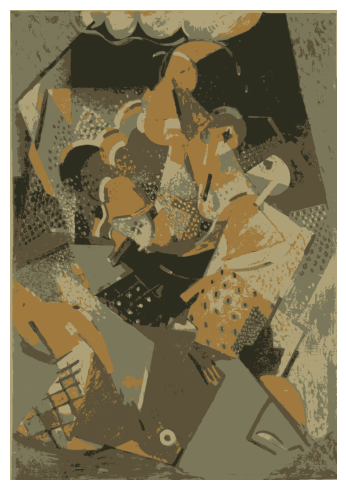

In [ ]:
# paleta de colores
show_palette(cluster_centers*255, "KMeans")
# imagen segmentada
plot_image(segmented_image.reshape(original_shape))

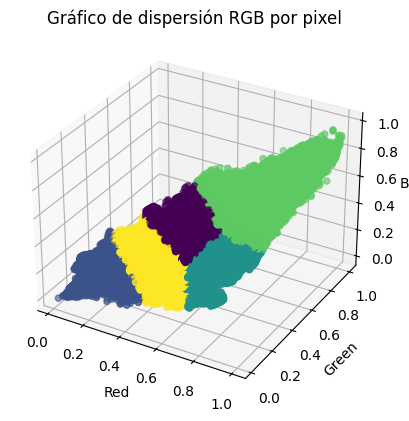

In [ ]:
### to do: pasarlo a función
# Gráfico de dispersión RGB por pixel
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(image.reshape(-1, 3)[:, 0], image.reshape(-1, 3)[:, 1], image.reshape(-1, 3)[:, 2], c=labels, cmap='viridis')
plt.title('Gráfico de dispersión RGB por pixel')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()


## K - medoids

In [13]:
dimension_resize = 128

def preprocesar_imagen(image_path,dimension_resize=dimension_resize):
    # cargar imagen
    image = cv2.imread(image_path)
    # Convertir a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar
    image = cv2.resize(image, (dimension_resize, dimension_resize))
    # Flatten the image
    image = image.reshape((-1, 3))
    # normalize
    image = image / 255.0
    return image


k = 5
# Modelo
kmedoids = KMedoids(n_clusters=k)


# Entrenamos el modelo
kmedoids.fit(preprocesar_imagen(images_list[0]))

cluster_centers = kmedoids.cluster_centers_
labels = kmedoids.labels_
segmented_image = cluster_centers[labels].reshape((dimension_resize,dimension_resize,3))


d:\Python\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


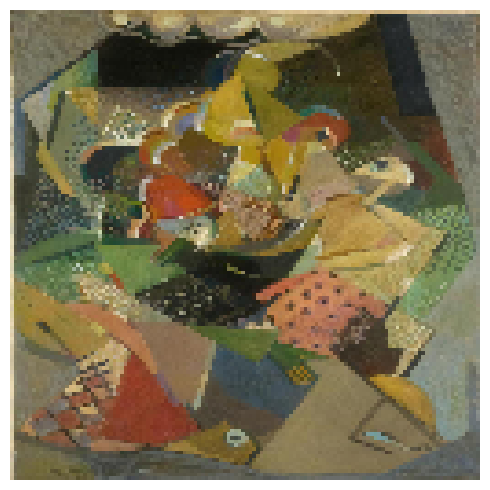

In [19]:
plot_image(preprocesar_imagen(images_list[0]).reshape((dimension_resize,dimension_resize,3)))

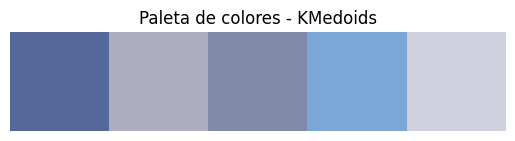

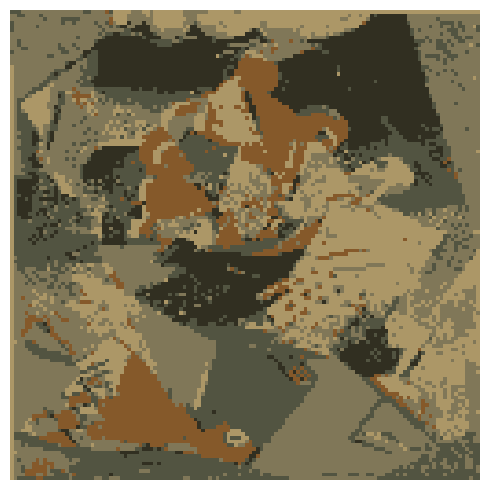

In [20]:
# paleta de colores
show_palette(cluster_centers*255, "KMedoids")
# imagen segmentada
plot_image(segmented_image.reshape((dimension_resize,dimension_resize,3)))

## DBSCAN

In [ ]:
pixels = image.reshape((-1, 3))

# seleccionar el 5% de los datos para entrenar el modelo más rápido
n_samples = int(pixels.shape[0] * 0.05)
idx = np.random.choice(pixels.shape[0], n_samples, replace=False)
pixels = pixels[idx]

# epsilon
eps = 10
# min_samples
min_samples = 100


# Create DBSCAN instance
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit DBSCAN to the pixel data
dbscan.fit(pixels)

# Get cluster labels
labels = dbscan.labels_
   

In [ ]:
# paleta de colores
show_palette(cluster_centers*255, "DBSCAN")
# imagen segmentada
# plot_image(segmented_image.reshape(original_shape))

## Aglomerativo

In [ ]:
pixels = image.reshape((-1, 3))

# seleccionar el 5% de los datos para entrenar el modelo más rápido
n_samples = int(pixels.shape[0] * 0.01)
idx = np.random.choice(pixels.shape[0], n_samples, replace=False)
pixels = pixels[idx]

k=5

# Modelo
aglo = AgglomerativeClustering(n_clusters=k, linkage="ward")

# Entrenamos el modelo
cluster_labels = aglo.fit_predict(pixels)
cluster_centers = np.array([pixels[cluster_labels == i].mean(axis=0) for i in range(k)])

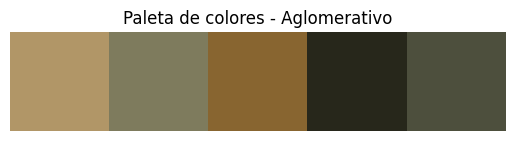

In [ ]:
# paleta de colores
show_palette(cluster_centers*255, "Aglomerativo")
# imagen segmentada
plot_image(segmented_image.reshape(original_shape))

## Conclusión

Los algortimos más eficientes en términos de tiempo serían Kmeans y Aglomerativo, dado que las imágenes son de alta resolución toma bastante tiempo en procesarla o simplemente no caben en memoria.

# Pipeline

In [6]:
dimension_resize = 500

def preprocesar_imagen(image_path,dimension_resize=dimension_resize):
    # cargar imagen
    image = cv2.imread(image_path)
    # Convertir a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar
    image = cv2.resize(image, (dimension_resize, dimension_resize))
    # Flatten the image
    image = image.reshape((-1, 3))
    # normalize
    image = image / 255.0
    return image


# Parámetros KMeans
kmeans_params = {
    'n_clusters': 7,
    'init': 'k-means++',  
    'max_iter': 300,       
    'random_state': 100     
}


# Pipeline
pipeline = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)),
    ('modelo_kmeans', KMeans(**kmeans_params))
])



## Pruebas

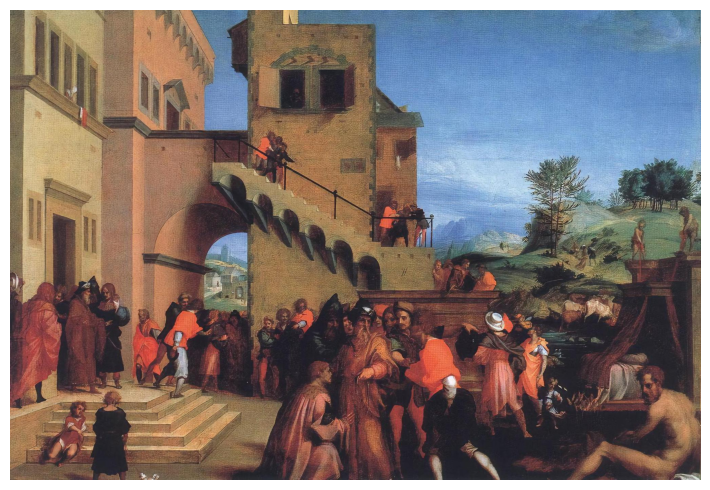

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


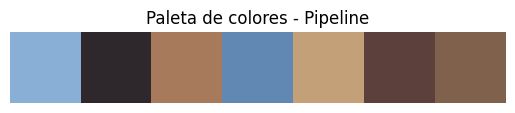

In [7]:
## selector de imagen para el pipeline
image_path = images_list[125]
# imagen original
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
original_shape = image.shape
original_image = image
plot_image(image)


pipeline_palette = pipeline.fit(image_path)

# Obtener los centros de los clusters
cluster_centers = pipeline_palette.named_steps['modelo_kmeans'].cluster_centers_
# Mostrar la paleta de colores
show_palette(cluster_centers, "Pipeline")


In [129]:
# random test
n_test = 10
np.random.seed(100)
idx = np.random.choice(len(images_list), n_test, replace=False)


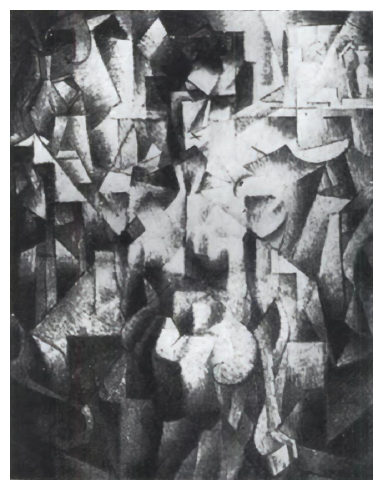

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


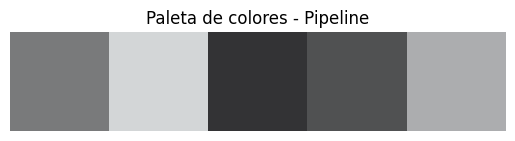

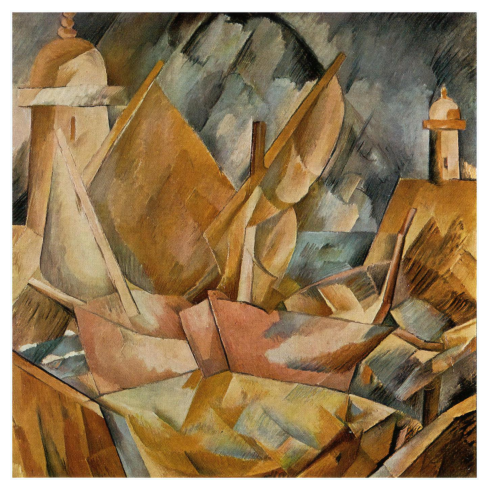

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


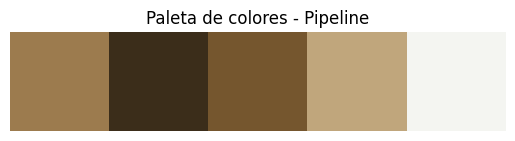

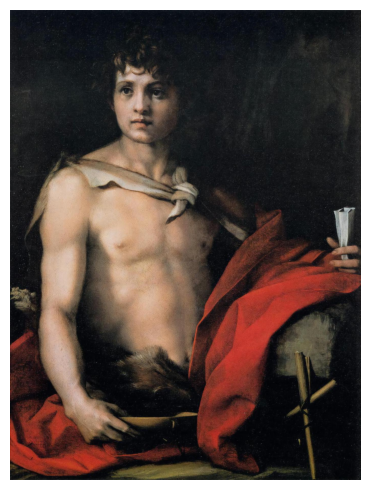

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


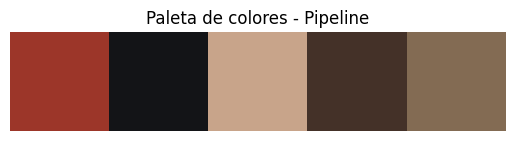

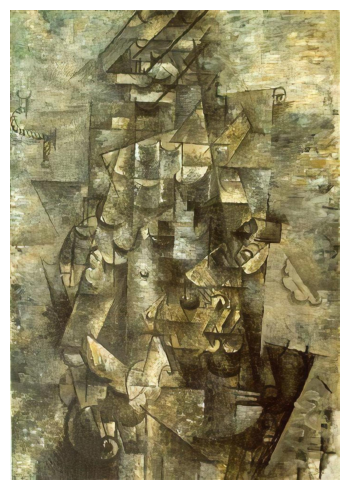

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


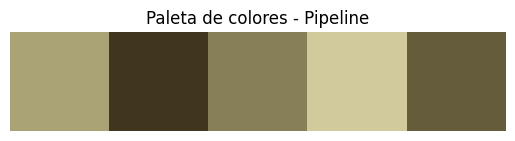

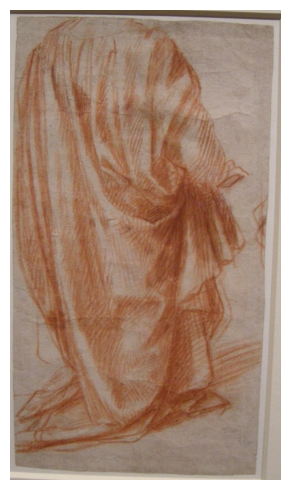

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


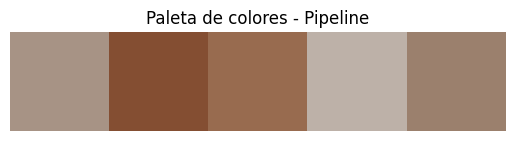

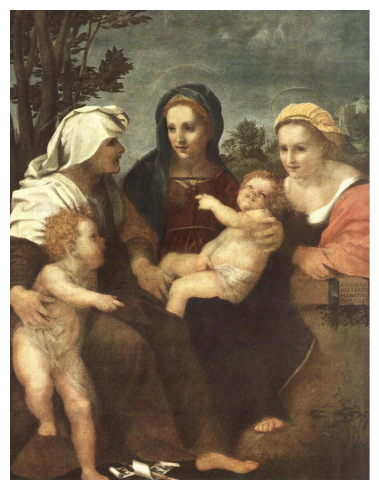

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


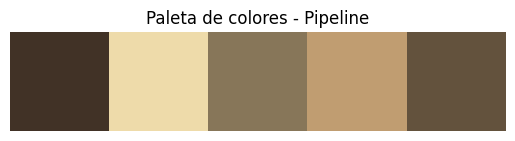

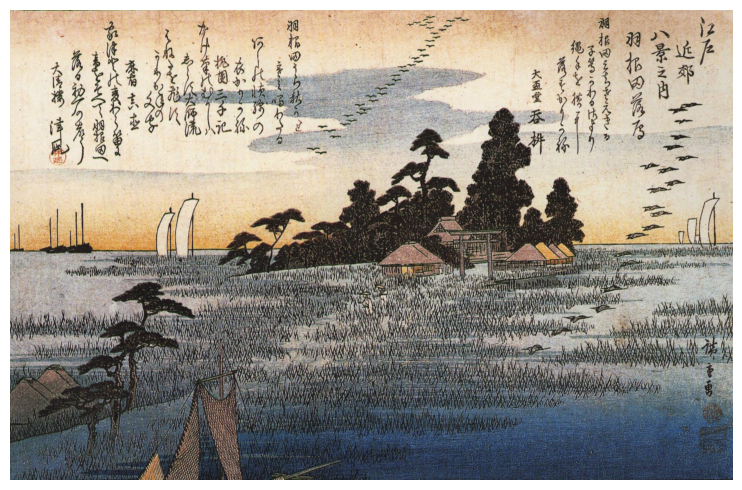

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


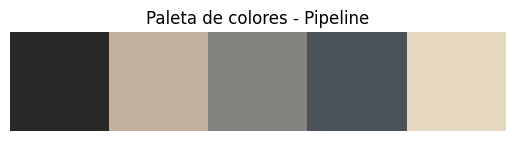

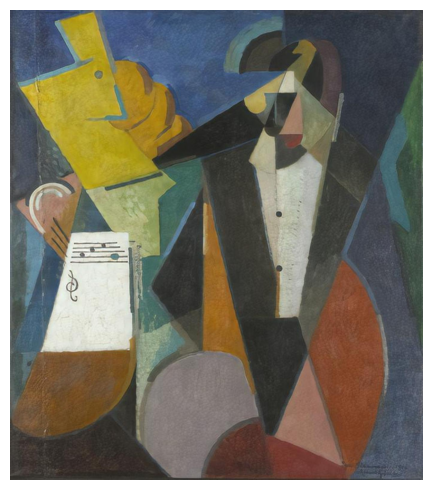

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


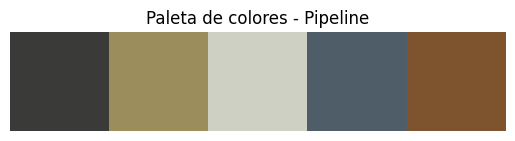

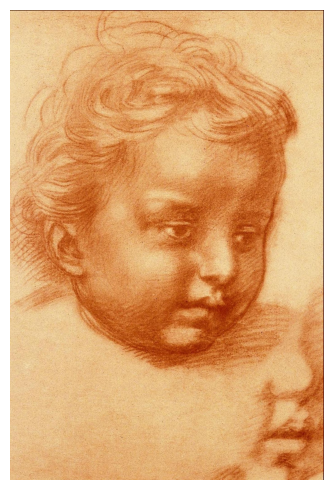

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


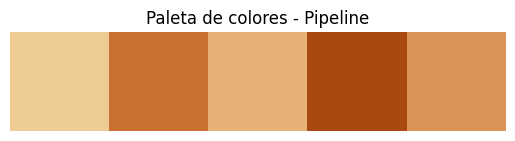

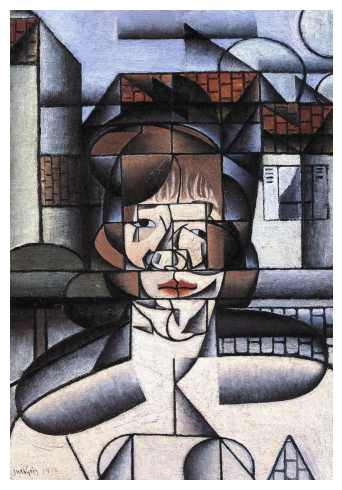

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


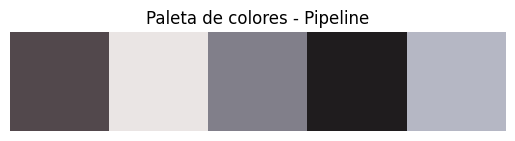

In [131]:
for i in idx:
    ## selector de imagen para el pipeline
    image_path = images_list[i]
    # imagen original
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    original_shape = image.shape
    original_image = image
    plot_image(image)


    pipeline_palette = pipeline.fit(image_path)

    # Obtener los centros de los clusters
    cluster_centers = pipeline_palette.named_steps['modelo_kmeans'].cluster_centers_
    # Mostrar la paleta de colores
    show_palette(cluster_centers, "Pipeline")